In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib
import matplotlib.pyplot as plt

import yellowbrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('yellowbrick version : ', yellowbrick.__version__, '\n')
print('sklearn version : ', sklearn.__version__, '\n')
print('xgboost version :', xgb.__version__)

pandas version :  1.2.4 

numpy version :  1.19.5 

matplotlib version :  3.3.4 

yellowbrick version :  1.3.post1 

sklearn version :  1.0.2 

xgboost version : 1.5.1


# Fonctions

Nous allons créer 4 fonctions afin d'être plus efficace dans la prédiction de la consommation énergétique et des émissions de CO2 de bâtiments. La première sera focalisée sur le preprocessing de nos données, la deuxième permettra d'appliquer un modèle de Machine Learning à nos données, la troisième réalisera un RandomizedSearchCV et la quatrième permettra de réaliser un GridSearchCV.

In [3]:
#On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

In [4]:
def preprocessing(data, target):
    """
    Prend un DataFrame et le sépare en deux : des features et une target. Sépare ensuite ces features et cet target en jeux
    d'entraînement et en jeux de test. Les features numériques seront centrés et réduits. Les features catégorielles
    seront transformés en features numériques à l'aide d'un ColumnTransformer et d'un OneHotEncoder. 
    Retourne X_train (features d'entraînement), X_test (features de test), y_train (target d'entraînement) et y_test (target
    de test).

            Parameters:
                data : DataFrame à utiliser
                target : variable que l'on souhaite prédire
    """
    
    #On sépare notre jeu de données entre nos features (X) et notre target (y)
    X = data.drop(target, axis = 1)
    y = data[target]
    
    #On sépare nos features et notre target en jeux d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)
    
    #On centre et on réduit nos valeurs numériques
    columns_to_scale  = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',\
                         'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',\
                         'AgeOfBuilding', '%GFAParking','%GFABuilding(s)', '%GFALargest', '%GFASecondLargest',\
                         '%SteamType', '%ElectricityType', '%GasType', '%OtherFuelType', '%SteamNeighbor',\
                         '%ElectricityNeighbor', '%GasNeighbor', '%OtherFuelNeighbor']

    std_scale = StandardScaler().fit(X_train[columns_to_scale])

    X_train[columns_to_scale] = std_scale.transform (X_train[columns_to_scale])
    X_test[columns_to_scale] = std_scale.transform(X_test[columns_to_scale])
    
    #On s'occupe de nos features catégorielles avec OneHotEncoder et ColumnTransformer
    columns_to_encode = ['Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']

    ct = ColumnTransformer([('onehotencoder', OneHotEncoder(handle_unknown = 'ignore', sparse = False), columns_to_encode)],\
                           remainder = 'passthrough')

    X_train = ct.fit_transform(X_train)

    X_test = ct.transform(X_test)
    
    features = ct.get_feature_names_out()
    
    return(X_train, X_test, y_train, y_test, features)

In [5]:
#On crée un dictionnaire qui va contenir nos modèles les résultats associés et les temps de calcul
data_model = {}

def algo(model, X_train, X_test, y_train, y_test):
    """
    Prend un modèle de Machine Learning et l'applique à nos données précédemment fournies (X_train, X_test, y_train, y_test).
    Calcule le coefficient de détermination R2 du jeu d'entraînement et du jeu de test ainsi que la racinde de l'erreur 
    quadratique moyenne (RMSE) associée. Ajoute le nom du modèle, le coefficient de détermination R2 du jeu d'entraînement
    et du jeu de test, ainsi que la racine de l'erreur quadratique moyenne du jeu de test et le temps de calcul de la cellule
    à un dictionnaire spécifique (data_model).
    
            Parameters:
                model : modèle que l'on souhaite tester
                X_train : features d'entraînement
                X_test : features de test
                y_train : target d'entraînement
                y_test : target de test
    """    
    #On souhaite savoir combien de temps nos modèles prennent à se faire
    t0 = time.time()
    
    #On entraîne notre modèle
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #On calcule le temps de calcul
    t1 = time.time()
    
    #On remplit notre dataframe avec les modèles, les scores associés et les temps de calcul
    data_model.update({'{}'.format(model) : ['{:.4f}'.format(model.score(X_train, y_train)),\
                                             '{:.4f}'.format(model.score(X_test, y_test)),\
                                             '{:.2f}'.format(rmse), '{:.2f}'.format(round(t1 - t0, 2))]})

In [6]:
#On crée un dictionnaire qui va contenir nos modèles les résultats associés et les temps de calcul
data_random = {}

def random_cv(model, params_grid, X_train, X_test, y_train, y_test):
    """
    Prend un modèle de Machine Learning et réalise un RandomizedSearchCV selon les paramètres spécifiés.
    Ajoute les meilleurs hyparamètres du modèle choisi, le modèle à utiliser, le meilleur score moyen avec les meilleurs
    hyperparamètres de validation croisée (coefficient de détermination R2), l'erreur quadratique moyenne du meilleur modèle
    ainsi que le temps de calcul de la validation croisée à un dictionnaire spécifique (data_random).
    
            Parameters:
                model : modèle que l'on souhaite tester avec une validation croisée
                params_grid : les paramètres à tester
                X_train : features d'entraînement
                X_test : features de test
                y_train : target d'entraînement
                y_test : target de test
    """
    #On affiche le temps de calcul de la recherche croisée
    t0 = time.time()

    model_cv = RandomizedSearchCV(model, params_grid, verbose = 1, cv = 5, scoring = 'r2')             

    model_cv.fit(X_train, y_train)
    
    best_hyperparam = model_cv.best_params_
    best_model_cv = model_cv.best_estimator_
    
    #Score moyen des validations croisées du meilleur estimateur
    best_score_cv = model_cv.best_score_

    #On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne avec les valeurs de la RandomizedSearch
    y_pred_cv = best_model_cv.predict(X_test)
    rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred_cv))
    
    #Temps de calcul :
    t1 = time.time()
    
    #On remplit notre dataframe avec les modèles, les scores associés et les temps de calcul
    data_random.update({'{}'.format(model) : ['{}'.format(best_hyperparam), '{:.4f}'.format(best_score_cv),\
                                             '{:.2f}'.format(rmse_cv), '{:.2f}'.format(round(t1 - t0, 2))]})

In [7]:
def algo_cv(model, params_grid, X_train, X_test, y_train, y_test):
    """
    Prend un modèle de Machine Learning et réalise un GridSearch et une validation croisée selon les paramètres spécifiés.
    Retourne les meilleurs hyparamètres du modèle choisi, le modèle à utiliser, le meilleur score moyen avec les meilleurs
    hyperparamètres de validation croisée (coefficient de détermination R2), l'erreur quadratique moyenne du meilleur modèle
    ainsi que le temps de calcul de la validation croisée.
    
            Parameters:
                model : modèle que l'on souhaite tester avec une validation croisée
                params_grid : les paramètres à tester
                X_train : features d'entraînement
                X_test : features de test
                y_train : target d'entraînement
                y_test : target de test
    """
    #On affiche le temps de calcul de la recherche croisée
    t0 = time.time()

    model_cv = GridSearchCV(model, params_grid, verbose = 1, cv = 5, scoring = 'r2')             

    model_cv.fit(X_train, y_train) 

    print("Les meilleurs hyperparamètres du modèle sont :", model_cv.best_params_, '\n')
    print("Le modèle à utiliser est :", model_cv.best_estimator_, '\n')

    best_model_cv = model_cv.best_estimator_
    
    #Score moyen des validations croisées du meilleur estimateur
    print("Le meilleur score avec ces hyperparamètres est : {:.4f}".format(model_cv.best_score_), '\n')

    #On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne avec les valeurs de la GridSearch
    y_pred_cv = best_model_cv.predict(X_test)
    rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred_cv))
    print("RMSE_CV : {:.2f}".format(rmse_cv), '\n')
    
    #Temps de calcul :
    t1 = time.time()
    print('Temps de calcul :', round(t1 - t0, 2), 'secondes')

In [8]:
#Liste des modèles que nous allons utiliser sur nos jeux de données
modeles = [DummyRegressor(strategy = 'mean'), LinearRegression(), Ridge(), Lasso(tol = 1e-2, max_iter = 4000),\
           KNeighborsRegressor(), RandomForestRegressor(), DecisionTreeRegressor(), AdaBoostRegressor(DecisionTreeRegressor()),\
           GradientBoostingRegressor(), XGBRegressor()]

In [9]:
#Les params_grid des RandomizedSearchCV que nous allons utiliser comme base pour chaque jeu de données
params_dummy ={'strategy' : ['mean', 'median', 'quantile'], 'quantile' : [0.0, 0.33, 0.66, 0.75]}

params_linear = {'fit_intercept' : [True, False], 'positive' : [True, False]}

params_ridge = {'alpha' : np.logspace(-3, 3), 'positive' : [True, False]}

params_lasso = {'alpha' : np.logspace(-5, 5), 'fit_intercept' : [True, False], 'positive' : [True, False]}

params_knn = {'n_neighbors' : np.arange(1, 15), 'weights' : ['uniform', 'distance'],\
              'metric': ['euclidean', 'manhattan', 'minkowski']}

params_forest = {'max_depth' : [None, 3, 5], 'min_samples_leaf' : [1, 5, 10], 'n_estimators' : np.arange(100, 500, 100)}

params_tree = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth' : [None, 3, 5],\
               'min_samples_leaf' : [1, 5, 10]}

params_ada = {'base_estimator__max_depth' : [None, 3, 5], 'base_estimator__min_samples_leaf' : [1, 5, 10],\
              'n_estimators' : np.arange(50, 300, 50), 'loss' : ['linear', 'square', 'exponential']}

params_gradient = {'learning_rate' : (0.05, 0.10, 0.15), 'n_estimators' : [100, 250, 500],\
                   'min_samples_leaf' : [1, 5, 10], 'max_depth' : [3, 6, 8]}

params_xgbr = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [4, 6, 8],\
               'gamma' : [ 0.0, 0.1, 0.2], 'n_estimators' : [100, 250, 500]}

params_list = [params_dummy, params_linear, params_ridge, params_lasso, params_knn, params_forest, params_tree,\
               params_ada, params_gradient, params_xgbr]

# Prédictions des consommations énergétiques sans ENERGYSTARScore

## 1ères prédictions - Consommations énergétiques sans ENERGYSTARScore

In [10]:
#On charge notre jeu de données
elec_no_star = pd.read_csv('P4_elec.csv')
elec_no_star.drop(columns = ['Unnamed: 0', 'ENERGYSTARScore'], inplace = True)
print('Notre jeu de données comporte :', elec_no_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [11]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = elec_no_star, target = 'SiteEnergyUse(kBtu)')

In [12]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [13]:
#On regroupe nos résultats dans un DataFrame
df_elec_no_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                  'RMSE', 'Temps de calcul'])
df_elec_no_star.sort_values('Score de test', ascending = False, inplace = True)
df_elec_no_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9997,0.8551,0.51,1.34
RandomForestRegressor(),0.9792,0.8427,0.53,1.89
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9753,0.8268,0.56,0.28
GradientBoostingRegressor(),0.8352,0.7884,0.62,0.72
DecisionTreeRegressor(),1.0000,0.7581,0.66,0.03
KNeighborsRegressor(),0.7707,0.6493,0.79,0.04
Ridge(),0.6480,0.0885,1.28,0.01
LinearRegression(),0.6548,-564731947975727120384.0000,31788704991.43,0.02
DummyRegressor(),0.0000,-0.0018,1.34,0.00
"Lasso(max_iter=4000, tol=0.01)",0.0000,-0.0018,1.34,0.01


## RandomizedSearchCV - Consommations énergétiques sans ENERGYSTARScore

In [14]:
for model, params in zip(modeles, params_list):
    random_cv(model, params_grid = params, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\victo\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
df_random_elec = pd.DataFrame.from_dict(data_random, orient = 'index', columns = ['Best Params', 'Best score',\
                                                                                  'RMSE', 'Temps de calcul'])
df_random_elec.sort_values('Best score', ascending = False, inplace = True)
df_random_elec.head(len(modeles))

,Best Params,Best score,RMSE,Temps de calcul
GradientBoostingRegressor(),"{'n_estimators': 500, 'min_samples_leaf': 5, '...",0.8485,0.50,180.48
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),"{'n_estimators': 250, 'loss': 'linear', 'base_...",0.8445,0.50,94.87
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)","{'n_estimators': 500, 'max_depth': 4, 'learnin...",0.8422,0.54,41.96
RandomForestRegressor(),"{'n_estimators': 100, 'min_samples_leaf': 5, '...",0.7819,0.59,63.28
KNeighborsRegressor(),"{'weights': 'distance', 'n_neighbors': 12, 'me...",0.7498,0.61,1.98
DecisionTreeRegressor(),"{'min_samples_leaf': 1, 'max_depth': None, 'cr...",0.7044,0.64,5.26
Ridge(),"{'positive': False, 'alpha': 0.15998587196060574}",0.5766,1.28,0.34
"Lasso(max_iter=4000, tol=0.01)","{'positive': False, 'fit_intercept': False, 'a...",0.5266,1.34,0.35
LinearRegression(),"{'positive': True, 'fit_intercept': False}",-0.2090,1.28,0.65
DummyRegressor(),"{'strategy': 'mean', 'quantile': 0.66}",-0.0019,1.34,0.09


## GridSearchCV - Consommations énergétique sans ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 6 meilleurs modèles, ceux qui ont un meilleur score supérieur à 0.7.

In [16]:
df_random_elec['Best Params'].head(6).unique()

array(["{'n_estimators': 500, 'min_samples_leaf': 5, 'max_depth': 8, 'learning_rate': 0.1}",
       "{'n_estimators': 250, 'loss': 'linear', 'base_estimator__min_samples_leaf': 5, 'base_estimator__max_depth': None}",
       "{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.0}",
       "{'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': None}",
       "{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan'}",
       "{'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'absolute_error'}"],
      dtype=object)

In [17]:
#GradientBoostingRegressor
params_grid = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [6, 8, 10], 'min_samples_leaf' : [3, 5, 7],\
               'n_estimators' : [400, 500, 600]}

algo_cv(GradientBoostingRegressor(), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 600} 

Le modèle à utiliser est : GradientBoostingRegressor(learning_rate=0.05, max_depth=8, min_samples_leaf=3,
                          n_estimators=600) 

Le meilleur score avec ces hyperparamètres est : 0.8514 

RMSE_CV : 0.51 

Temps de calcul : 2836.95 secondes


In [18]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 1, 2], 'base_estimator__min_samples_leaf' : [3, 5, 7],\
               'n_estimators' : [150, 250, 350]}

algo_cv(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss = 'linear'), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 3, 'n_estimators': 350} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=3),
                  n_estimators=350) 

Le meilleur score avec ces hyperparamètres est : 0.8534 

RMSE_CV : 0.49 

Temps de calcul : 242.72 secondes


In [19]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.10, 0.15, 0.20), 'max_depth' : [2, 4, 6],\
               'gamma' : [0.0, 0.05, 0.10], 'n_estimators' : [400, 500, 600]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.8538 

RMSE_CV : 0.53 

Temps de calcul : 297.14 secondes


In [20]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [3, 5, 7], 'n_estimators' : [50, 100, 150]}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 150} 

Le modèle à utiliser est : RandomForestRegressor(min_samples_leaf=3, n_estimators=150) 

Le meilleur score avec ces hyperparamètres est : 0.8055 

RMSE_CV : 0.55 

Temps de calcul : 71.75 secondes


In [21]:
#KNeighborsRegressor
params_grid = {'n_neighbors' : np.arange(10, 16), 'weights' : ['uniform', 'distance'],\
              'metric': ['euclidean', 'manhattan', 'minkowski']}

algo_cv(KNeighborsRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres du modèle sont : {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'} 

Le modèle à utiliser est : KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance') 

Le meilleur score avec ces hyperparamètres est : 0.7559 

RMSE_CV : 0.61 

Temps de calcul : 8.19 secondes


In [22]:
#DecisionTreeRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [1, 2, 3]}

algo_cv(DecisionTreeRegressor(criterion = 'absolute_error'), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1} 

Le modèle à utiliser est : DecisionTreeRegressor(criterion='absolute_error') 

Le meilleur score avec ces hyperparamètres est : 0.7206 

RMSE_CV : 0.66 

Temps de calcul : 13.33 secondes


## Analyse de notre meilleur modèle - Consommations énergétiques sans ENERGYSTARScore

In [12]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

xgbr =  XGBRegressor(gamma = 0.0, learning_rate = 0.2, max_depth = 6, n_estimators = 400) 

#On entraîne notre modèle
xgbr.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
xgbr_train = np.mean(cross_val_score(xgbr, X_train, y_train, cv = 10))
xgbr_test = np.mean(cross_val_score(xgbr, X_test, y_test, cv = 10))

print("Score d'entraînement : {:.4f}".format(xgbr_train), '\n')
print("Score de test : {:.4f}".format(xgbr_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = xgbr.predict(X_test)
xgbr_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))

print("RMSE : {}".format(xgbr_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
xgbr_time = round(t1 - t0, 2)

print('Temps de calcul :', xgbr_time, 'secondes')

Score d'entraînement : 0.8607 

Score de test : 0.7615 

RMSE : 26757503.91 

Temps de calcul : 14.65 secondes


On crée un dictionnaire qui va reprendre les informations relatives à nos meilleures modèles.

In [13]:
dict_final = {}

dict_final.update({'XGBoostRegressor Consommation énergétique' : [xgbr_train, xgbr_test, xgbr_rmse, xgbr_time]})

### Feature importance plot - Consommations énergétiques sans ENERGYSTARScore

<AxesSubplot:>

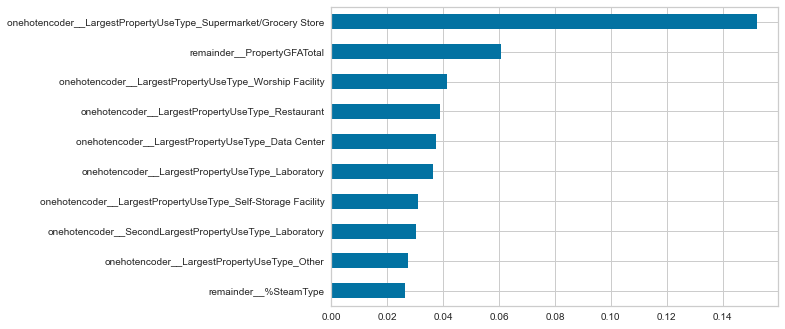

In [14]:
feat_importances_xgbr = pd.Series(xgbr.feature_importances_, index = features)

feat_importances_xgbr.nlargest(10).sort_values().plot(kind = 'barh')

### Learning curves plot - Consommations énergétiques sans ENERGYSTARScore

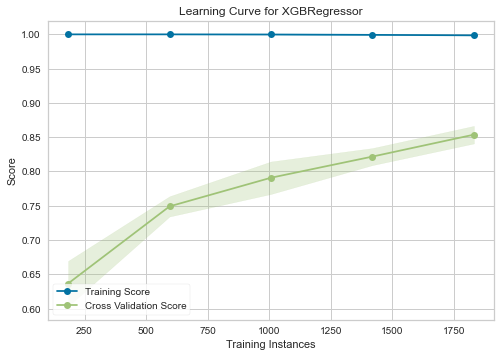

<AxesSubplot:title={'center':'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [15]:
learning_curve_xgbr = LearningCurve(xgbr, scoring = 'r2')

learning_curve_xgbr.fit(X_train, y_train)
learning_curve_xgbr.show()

### Residual plot - Consommations énergétiques sans ENERGYSTARScore

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

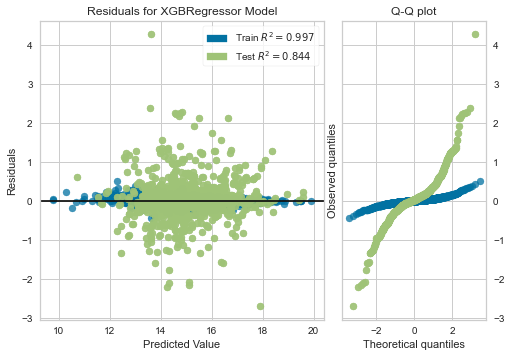

In [16]:
residual_plot_xgbr = ResidualsPlot(xgbr, hist = False, qqplot = True)

residual_plot_xgbr.fit(X_train, y_train)
residual_plot_xgbr.score(X_test, y_test) 
residual_plot_xgbr.finalize()

residuals = y_pred - y_test

residual_plot_xgbr.draw(y_pred, residuals) 

### Prediction Error plot - Consommations énergétiques sans ENERGYSTARScore

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

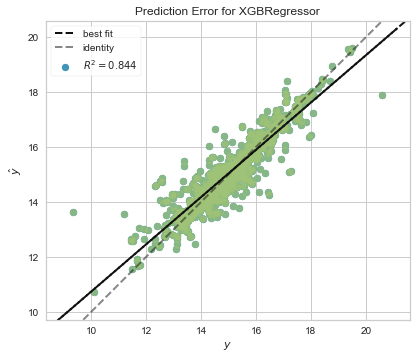

In [17]:
prediction_error_xgbr = PredictionError(xgbr)

prediction_error_xgbr.fit(X_train, y_train)
prediction_error_xgbr.score(X_test, y_test)
prediction_error_xgbr.finalize()

prediction_error_xgbr.draw(y_test, y_pred) 

# Prédictions des consommations énergétiques avec ENERGYSTARScore

## 1ères prédictions - Consommations énergétiques avec ENERGYSTARScore

In [18]:
#On charge notre jeu de données
elec_with_star = pd.read_csv('P4_elec.csv')
elec_with_star.drop(columns = ['Unnamed: 0'], inplace = True)
print('Notre jeu de données comporte :', elec_with_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [19]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = elec_with_star, target = 'SiteEnergyUse(kBtu)')

In [50]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [51]:
#On regroupe nos résultats dans un DataFrame
df_elec_with_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                    'RMSE', 'Temps de calcul'])
df_elec_with_star.sort_values('Score de test', ascending = False, inplace = True)
df_elec_with_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9998,0.8862,0.45,2.29
RandomForestRegressor(),0.9826,0.8704,0.48,3.46
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9841,0.8699,0.48,0.45
GradientBoostingRegressor(),0.8745,0.8259,0.56,1.43
DecisionTreeRegressor(),1.0000,0.7618,0.65,0.07
KNeighborsRegressor(),0.7191,0.5485,0.90,0.10
Ridge(),0.6852,0.1274,1.25,0.01
"Lasso(max_iter=4000, tol=0.01)",0.0175,0.0085,1.33,0.01
LinearRegression(),0.6949,-412600930772447.8125,27171696.75,0.02
DummyRegressor(),0.0000,-0.0018,1.34,0.00


## RandomizedSearchCV - Consommations énergétiques avec ENERGYSTARScore

In [52]:
for model, params in zip(modeles, params_list):
    random_cv(model, params_grid = params, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\victo\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [53]:
df_random_elec_ess = pd.DataFrame.from_dict(data_random, orient = 'index', columns = ['Best Params', 'Best score',\
                                                                                  'RMSE', 'Temps de calcul'])
df_random_elec_ess.sort_values('Best score', ascending = False, inplace = True)
df_random_elec_ess.head(len(modeles))

,Best Params,Best score,RMSE,Temps de calcul
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)","{'n_estimators': 500, 'max_depth': 8, 'learnin...",0.8850,0.45,36.87
GradientBoostingRegressor(),"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.8728,0.48,204.30
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),"{'n_estimators': 200, 'loss': 'linear', 'base_...",0.8508,0.48,82.88
RandomForestRegressor(),"{'n_estimators': 200, 'min_samples_leaf': 1, '...",0.8483,0.48,92.21
DecisionTreeRegressor(),"{'min_samples_leaf': 5, 'max_depth': None, 'cr...",0.7139,0.67,4.87
KNeighborsRegressor(),"{'weights': 'distance', 'n_neighbors': 3, 'met...",0.6851,0.69,3.98
Ridge(),"{'positive': False, 'alpha': 0.21209508879201905}",0.6151,1.26,0.71
"Lasso(max_iter=4000, tol=0.01)","{'positive': False, 'fit_intercept': False, 'a...",0.5996,1.32,0.64
LinearRegression(),"{'positive': True, 'fit_intercept': False}",0.4217,1.32,1.24
DummyRegressor(),"{'strategy': 'mean', 'quantile': 0.33}",-0.0019,1.34,0.20


## GridSearchCV - Consommations énergétiques avec ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 4 meilleurs modèles, ceux qui ont un meilleur score supérieur à 0.8.

In [54]:
df_random_elec_ess['Best Params'].head(4).unique()

array(["{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 0.0}",
       "{'n_estimators': 500, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.15}",
       "{'n_estimators': 200, 'loss': 'linear', 'base_estimator__min_samples_leaf': 10, 'base_estimator__max_depth': None}",
       "{'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': None}"],
      dtype=object)

In [55]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.10, 0.15, 0.20), 'max_depth' : [6, 8, 10],\
               'gamma' : [0.0, 0.05, 0.1], 'n_estimators' : [400, 500, 600]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 600} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.8904 

RMSE_CV : 0.45 

Temps de calcul : 619.97 secondes


In [56]:
#GradientBoostingRegressor
params_grid = {'learning_rate' : (0.10, 0.15, 0.20), 'max_depth' : [2, 3, 5], 'min_samples_leaf' : [1, 2, 3],\
               'n_estimators' : [400, 500, 600]}

algo_cv(GradientBoostingRegressor(loss = 'squared_error'), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'learning_rate': 0.15, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 600} 

Le modèle à utiliser est : GradientBoostingRegressor(learning_rate=0.15, max_depth=5, n_estimators=600) 

Le meilleur score avec ces hyperparamètres est : 0.8798 

RMSE_CV : 0.46 

Temps de calcul : 1428.97 secondes


In [57]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 1, 2], 'base_estimator__min_samples_leaf' : [8, 10, 12],\
               'n_estimators' : [150, 200, 250]}

algo_cv(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss = 'linear'), params_grid = params_grid,\
        X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 8, 'n_estimators': 200} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=8),
                  n_estimators=200) 

Le meilleur score avec ces hyperparamètres est : 0.8583 

RMSE_CV : 0.46 

Temps de calcul : 195.47 secondes


In [58]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [1, 2, 3], 'n_estimators' : [100, 200, 300]}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=200) 

Le meilleur score avec ces hyperparamètres est : 0.8489 

RMSE_CV : 0.48 

Temps de calcul : 174.72 secondes


## Analyse de notre meilleur modèle - Consommations énergétiques avec ENERGYSTARScore

Ici, nous allons uniquement regarder le Feature importance plot pour en apprendre plus sur l'intérêt de l'*ENERGYSTARScore*.

In [20]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

xgbr_ess = XGBRegressor(gamma = 0.0, learning_rate = 0.10, max_depth = 10, n_estimators = 600) 

#On entraîne notre modèle
xgbr_ess.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
xgbr_ess_train = np.mean(cross_val_score(xgbr_ess, X_train, y_train, cv = 10))
xgbr_ess_test = np.mean(cross_val_score(xgbr_ess, X_test, y_test, cv = 10))

print("Score d'entraînement : {:.4f}".format(xgbr_ess_train), '\n')
print("Score de test : {:.4f}".format(xgbr_ess_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = xgbr_ess.predict(X_test)
xgbr_ess_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
print("RMSE : {}".format(xgbr_ess_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
xgbr_ess_time = round(t1 - t0, 2)
print('Temps de calcul :', xgbr_ess_time, 'secondes')

Score d'entraînement : 0.8990 

Score de test : 0.8097 

RMSE : 27027840.62 

Temps de calcul : 35.82 secondes


In [21]:
dict_final.update({'XGBoostRegressor Consommation énergétique avec ESS' : [xgbr_ess_train, xgbr_ess_test,\
                                                                           xgbr_ess_rmse, xgbr_ess_time]})

<AxesSubplot:>

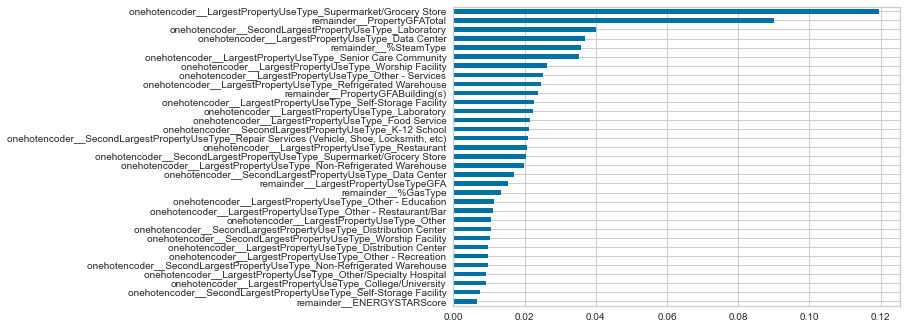

In [22]:
feat_importances_xgbr_ess = pd.Series(xgbr_ess.feature_importances_, index = features)

feat_importances_xgbr_ess.nlargest(33).sort_values().plot(kind = 'barh')

# Prédictions des émissions de CO2 sans ENERGYSTARScore

## 1ères prédictions - Emissions de CO2 sans ENERGYSTARScore

In [23]:
#On charge notre jeu de données
co2_no_star = pd.read_csv('P4_co2.csv')
co2_no_star.drop(columns = ['Unnamed: 0', 'ENERGYSTARScore'], inplace = True)
print('Notre jeu de données comporte :', co2_no_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [24]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = co2_no_star, target = 'TotalGHGEmissions')

In [65]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [66]:
#On regroupe nos résultats dans un DataFrame
df_co2_no_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                 'RMSE', 'Temps de calcul'])
df_co2_no_star.sort_values('Score de test', ascending = False, inplace = True)
df_co2_no_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9998,0.8940,0.47,1.29
RandomForestRegressor(),0.9838,0.8777,0.51,1.81
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9823,0.8747,0.51,0.25
GradientBoostingRegressor(),0.8828,0.8426,0.57,0.72
DecisionTreeRegressor(),1.0000,0.8013,0.65,0.02
KNeighborsRegressor(),0.8137,0.7133,0.77,0.04
Ridge(),0.7377,0.2538,1.25,0.01
LinearRegression(),0.7424,-273310249316539629568.0000,23924759059.37,0.01
DummyRegressor(),0.0000,-0.0001,1.45,0.00
"Lasso(max_iter=4000, tol=0.01)",0.0000,-0.0001,1.45,0.01


## RandomizedSearchCV - Emissions de CO2 sans ENERGYSTARScore

In [67]:
for model, params in zip(modeles, params_list):
    random_cv(model, params_grid = params, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\victo\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [68]:
df_random_co2 = pd.DataFrame.from_dict(data_random, orient = 'index', columns = ['Best Params', 'Best score',\
                                                                                  'RMSE', 'Temps de calcul'])
df_random_co2.sort_values('Best score', ascending = False, inplace = True)
df_random_co2.head(len(modeles))

,Best Params,Best score,RMSE,Temps de calcul
GradientBoostingRegressor(),"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.8811,0.49,146.90
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)","{'n_estimators': 250, 'max_depth': 6, 'learnin...",0.8744,0.52,34.58
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),"{'n_estimators': 200, 'loss': 'square', 'base_...",0.8722,0.48,78.26
RandomForestRegressor(),"{'n_estimators': 300, 'min_samples_leaf': 1, '...",0.8634,0.50,98.07
KNeighborsRegressor(),"{'weights': 'distance', 'n_neighbors': 8, 'met...",0.7977,0.58,2.32
DecisionTreeRegressor(),"{'min_samples_leaf': 5, 'max_depth': None, 'cr...",0.7600,0.67,2.28
Ridge(),"{'positive': False, 'alpha': 2.023589647725158}",0.6848,1.25,0.31
"Lasso(max_iter=4000, tol=0.01)","{'positive': False, 'fit_intercept': True, 'al...",0.6818,1.26,0.57
LinearRegression(),"{'positive': True, 'fit_intercept': False}",0.6409,1.25,0.67
DummyRegressor(),"{'strategy': 'mean', 'quantile': 0.66}",-0.0039,1.45,0.16


## GridSearchCV - Emissions de CO2 sans ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 6 meilleurs modèles, ceux qui ont un meilleur score supérieur à 0.7.

In [69]:
df_random_co2['Best Params'].head(6).unique()

array(["{'n_estimators': 500, 'min_samples_leaf': 1, 'max_depth': 6, 'learning_rate': 0.05}",
       "{'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1}",
       "{'n_estimators': 200, 'loss': 'square', 'base_estimator__min_samples_leaf': 5, 'base_estimator__max_depth': None}",
       "{'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': None}",
       "{'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}",
       "{'min_samples_leaf': 5, 'max_depth': None, 'criterion': 'squared_error'}"],
      dtype=object)

In [70]:
#GradientBoostingRegressor
params_grid = {'learning_rate' : (0.02, 0.05, 0.07), 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [1, 2, 3],\
               'n_estimators' : [400, 500, 600]}

algo_cv(GradientBoostingRegressor(loss = 'squared_error'), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'learning_rate': 0.07, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 600} 

Le modèle à utiliser est : GradientBoostingRegressor(learning_rate=0.07, max_depth=6, min_samples_leaf=3,
                          n_estimators=600) 

Le meilleur score avec ces hyperparamètres est : 0.8852 

RMSE_CV : 0.47 

Temps de calcul : 2212.83 secondes


In [71]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.10, 0.15, 0.20), 'max_depth' : [4, 6, 8],\
               'gamma' : [0.05, 0.1, 0.15], 'n_estimators' : [200, 250, 350]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.05, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 200} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.05, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.8779 

RMSE_CV : 0.52 

Temps de calcul : 217.97 secondes


In [72]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 1, 2], 'base_estimator__min_samples_leaf' : [3, 5, 7],\
               'n_estimators' : [100, 200, 300]}

algo_cv(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss = 'square'), params_grid = params_grid,\
        X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 3, 'n_estimators': 200} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=3),
                  loss='square', n_estimators=200) 

Le meilleur score avec ces hyperparamètres est : 0.8807 

RMSE_CV : 0.47 

Temps de calcul : 229.58 secondes


In [73]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [1, 2, 3], 'n_estimators' : [200, 300, 400]}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=400) 

Le meilleur score avec ces hyperparamètres est : 0.8637 

RMSE_CV : 0.50 

Temps de calcul : 241.58 secondes


In [74]:
#KNeighborsRegressor
params_grid = {'n_neighbors' : np.arange(4, 15), 'weights' : ['uniform', 'distance'],\
              'metric': ['euclidean', 'manhattan', 'minkowski']}

algo_cv(KNeighborsRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
Les meilleurs hyperparamètres du modèle sont : {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'} 

Le modèle à utiliser est : KNeighborsRegressor(metric='manhattan', n_neighbors=6, weights='distance') 

Le meilleur score avec ces hyperparamètres est : 0.7993 

RMSE_CV : 0.58 

Temps de calcul : 14.82 secondes


In [75]:
#DecisionTreeRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [3, 5, 7]}

algo_cv(DecisionTreeRegressor(criterion = 'squared_error'), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 3} 

Le modèle à utiliser est : DecisionTreeRegressor(min_samples_leaf=3) 

Le meilleur score avec ces hyperparamètres est : 0.7653 

RMSE_CV : 0.66 

Temps de calcul : 0.47 secondes


## Analyse de notre meilleur modèle - Emissions de CO2 sans ENERGYSTARScore

In [25]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

gbr_co2 = GradientBoostingRegressor(learning_rate = 0.07, max_depth = 6, min_samples_leaf = 3, n_estimators = 600) 

#On entraîne notre modèle
gbr_co2.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
gbr_co2_train = np.mean(cross_val_score(gbr_co2, X_train, y_train, cv = 10))
gbr_co2_test = np.mean(cross_val_score(gbr_co2, X_test, y_test, cv = 10))

print("Score d'entraînement : {:.4f}".format(gbr_co2_train), '\n')
print("Score de test : {:.4f}".format(gbr_co2_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = gbr_co2.predict(X_test)
gbr_co2_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
print("RMSE : {}".format(gbr_co2_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
gbr_co2_time = round(t1 - t0, 2)
print('Temps de calcul :', gbr_co2_time, 'secondes')

Score d'entraînement : 0.8914 

Score de test : 0.8176 

RMSE : 352.99 

Temps de calcul : 113.98 secondes


In [26]:
dict_final.update({'GradientBoostingRegressor Emissions de CO2' : [gbr_co2_train, gbr_co2_test, gbr_co2_rmse, gbr_co2_time]})

### Feature importance plot - Emissions de CO2 sans ENERGYSTARScore

<AxesSubplot:>

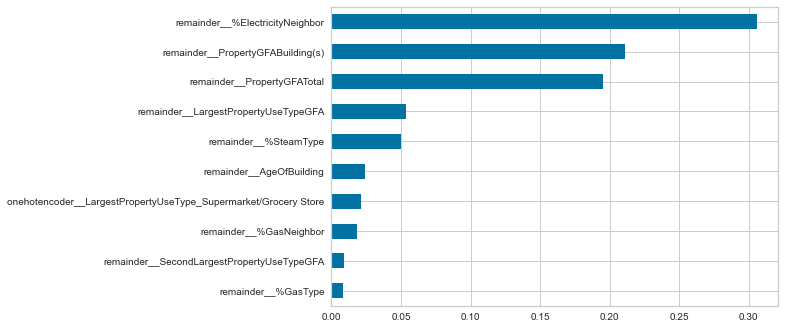

In [27]:
feat_importances_gbr_co2 = pd.Series(gbr_co2.feature_importances_, index = features)

feat_importances_gbr_co2.nlargest(10).sort_values().plot(kind = 'barh')

### Learning curves plot - Emissions de CO2 sans ENERGYSTARScore

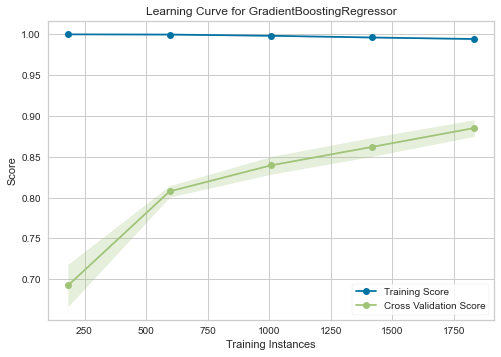

<AxesSubplot:title={'center':'Learning Curve for GradientBoostingRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [28]:
learning_curve_gbr_co2 = LearningCurve(gbr_co2, scoring = 'r2')

learning_curve_gbr_co2.fit(X_train, y_train)
learning_curve_gbr_co2.show()

### Residual plot - Emissions de CO2 sans ENERGYSTARScore

<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

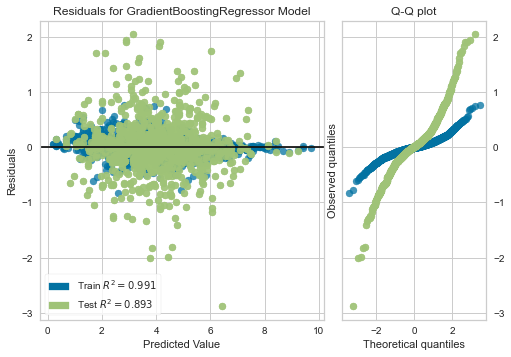

In [29]:
residual_plot_gbr_co2 = ResidualsPlot(gbr_co2, hist = False, qqplot = True)

residual_plot_gbr_co2.fit(X_train, y_train)
residual_plot_gbr_co2.score(X_test, y_test) 
residual_plot_gbr_co2.finalize()
residuals = y_pred - y_test

residual_plot_gbr_co2.draw(y_pred, residuals) 

### Prediction Error plot - Emissions de CO2 sans ENERGYSTARScore

<AxesSubplot:title={'center':'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

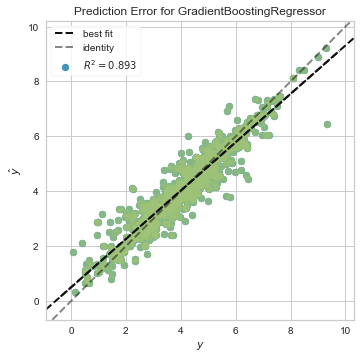

In [30]:
#Prediction Error Plot
prediction_error_gbr_co2 = PredictionError(gbr_co2)

prediction_error_gbr_co2.fit(X_train, y_train)
prediction_error_gbr_co2.score(X_test, y_test)
prediction_error_gbr_co2.finalize()
prediction_error_gbr_co2.draw(y_test, y_pred) 

# Prédictions des émissions de CO2 avec ENERGYSTARScore

## 1ères prédictions - Emissions de CO2 avec ENERGYSTARScore

In [31]:
#On charge notre jeu de données
co2_with_star = pd.read_csv('P4_co2.csv')
co2_with_star.drop(columns = ['Unnamed: 0'], inplace = True)
print('Notre jeu de données comporte :', co2_with_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [32]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = co2_with_star, target = 'TotalGHGEmissions')

In [84]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [85]:
#On regroupe nos résultats dans un DataFrame
df_co2_with_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                   'RMSE', 'Temps de calcul'])
df_co2_with_star.sort_values('Score de test', ascending = False, inplace = True)
df_co2_with_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9998,0.9125,0.43,1.35
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9914,0.9098,0.43,0.27
RandomForestRegressor(),0.9857,0.8941,0.47,1.89
GradientBoostingRegressor(),0.9122,0.8740,0.51,0.75
DecisionTreeRegressor(),1.0000,0.8220,0.61,0.03
KNeighborsRegressor(),0.7483,0.6043,0.91,0.05
Ridge(),0.7646,0.2831,1.23,0.01
"Lasso(max_iter=4000, tol=0.01)",0.0130,0.0095,1.44,0.01
LinearRegression(),0.7714,-21499102957277.4336,6710112.22,0.01
DummyRegressor(),0.0000,-0.0001,1.45,0.00


## RandomizedSearchCV - Emissions de CO2 avec ENERGYSTARScore

In [86]:
for model, params in zip(modeles, params_list):
    random_cv(model, params_grid = params, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\victo\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [87]:
df_random_co2_ess = pd.DataFrame.from_dict(data_random, orient = 'index', columns = ['Best Params', 'Best score',\
                                                                                  'RMSE', 'Temps de calcul'])
df_random_co2_ess.sort_values('Best score', ascending = False, inplace = True)
df_random_co2_ess.head(len(modeles))

,Best Params,Best score,RMSE,Temps de calcul
GradientBoostingRegressor(),"{'n_estimators': 500, 'min_samples_leaf': 5, '...",0.9072,0.41,176.27
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),"{'n_estimators': 250, 'loss': 'square', 'base_...",0.8973,0.41,124.20
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)","{'n_estimators': 500, 'max_depth': 4, 'learnin...",0.8968,0.46,26.81
RandomForestRegressor(),"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.8764,0.47,89.37
DecisionTreeRegressor(),"{'min_samples_leaf': 10, 'max_depth': None, 'c...",0.7473,0.67,3.36
"Lasso(max_iter=4000, tol=0.01)","{'positive': False, 'fit_intercept': True, 'al...",0.7091,1.23,0.69
Ridge(),"{'positive': False, 'alpha': 0.03906939937054617}",0.7060,1.23,0.53
KNeighborsRegressor(),"{'weights': 'distance', 'n_neighbors': 8, 'met...",0.6961,0.72,3.39
LinearRegression(),"{'positive': True, 'fit_intercept': False}",0.6419,1.25,0.67
DummyRegressor(),"{'strategy': 'mean', 'quantile': 0.0}",-0.0039,1.45,0.09


## GridSearchCV - Emissions de CO2 avec ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 4 meilleurs modèles, ceux qui ont un meilleur score supérieur à 0.8.

In [88]:
df_random_co2_ess['Best Params'].head(4).unique()

array(["{'n_estimators': 500, 'min_samples_leaf': 5, 'max_depth': 6, 'learning_rate': 0.15}",
       "{'n_estimators': 250, 'loss': 'square', 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': None}",
       "{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1}",
       "{'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': None}"],
      dtype=object)

In [89]:
#GradientBoostingRegressor
params_grid = {'learning_rate' : (0.10, 0.15, 0.20), 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [3, 5, 7],\
               'n_estimators' : [400, 500, 600]}

algo_cv(GradientBoostingRegressor(), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'learning_rate': 0.15, 'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 600} 

Le modèle à utiliser est : GradientBoostingRegressor(learning_rate=0.15, max_depth=4, min_samples_leaf=3,
                          n_estimators=600) 

Le meilleur score avec ces hyperparamètres est : 0.9124 

RMSE_CV : 0.41 

Temps de calcul : 2248.14 secondes


In [90]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 1, 2], 'base_estimator__min_samples_leaf' : [1, 2, 3],\
               'n_estimators' : [150, 250, 350]}

algo_cv(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss = 'square'), params_grid = params_grid,\
        X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'n_estimators': 250} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), loss='square',
                  n_estimators=250) 

Le meilleur score avec ces hyperparamètres est : 0.8971 

RMSE_CV : 0.41 

Temps de calcul : 308.52 secondes


In [91]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.02, 0.05, 0.07), 'max_depth' : [2, 4, 6],\
               'gamma' : [0.0, 0.1, 0.2], 'n_estimators' : [400, 500, 600]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 600} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.9095 

RMSE_CV : 0.42 

Temps de calcul : 298.77 secondes


In [92]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 1, 2], 'min_samples_leaf' : [1, 2, 3], 'n_estimators' : [50, 100, 150]}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=150) 

Le meilleur score avec ces hyperparamètres est : 0.8793 

RMSE_CV : 0.47 

Temps de calcul : 84.54 secondes


## Analyse de notre meilleur modèle - Emissions de CO2 avec ENERGYSTARScore

De nouveau, nous allons uniquement nous intéresser au Feagture importance plot pour notre modèle qui prend en compte l'*ENERGYSTARScore*".

In [33]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

gbr_co2_ess = GradientBoostingRegressor(learning_rate = 0.15, max_depth = 4, min_samples_leaf = 3, n_estimators = 600) 

#On entraîne notre modèle
gbr_co2_ess.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
gbr_co2_ess_train = np.mean(cross_val_score(gbr_co2_ess, X_train, y_train, cv = 10))
gbr_co2_ess_test = np.mean(cross_val_score(gbr_co2_ess, X_test, y_test, cv = 10))

print("Score d'entraînement : {:.4f}".format(gbr_co2_ess_train), '\n')
print("Score de test : {:.4f}".format(gbr_co2_ess_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = gbr_co2_ess.predict(X_test)
gbr_co2_ess_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
print("RMSE : {}".format(gbr_co2_ess_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
gbr_co2_ess_time = round(t1 - t0, 2)
print('Temps de calcul :', gbr_co2_ess_time, 'secondes')

Score d'entraînement : 0.9188 

Score de test : 0.8535 

RMSE : 356.09 

Temps de calcul : 78.79 secondes


In [34]:
dict_final.update({'GradientBoostingRegressor Emissions de CO2 avec ESS' : [gbr_co2_ess_train, gbr_co2_ess_test,\
                                                                            gbr_co2_ess_rmse, gbr_co2_ess_time]})

<AxesSubplot:>

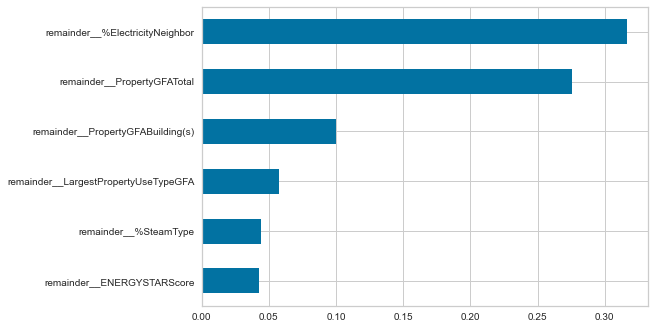

In [35]:
feat_importances_gbr_co2_ess = pd.Series(gbr_co2_ess.feature_importances_, index = features)

feat_importances_gbr_co2_ess.nlargest(6).sort_values().plot(kind = 'barh')

# Nos modèles finaux :

In [36]:
df_final = pd.DataFrame.from_dict(dict_final, orient = 'index', columns = ["Score d'entraînement", 'Score de test',\
                                                                                 'RMSE', 'Temps de calcul'])
df_final.head()

,Score d'entraînement,Score de test,RMSE,Temps de calcul
XGBoostRegressor Consommation énergétique,0.860692,0.761498,26757503.91,14.65
XGBoostRegressor Consommation énergétique avec ESS,0.899034,0.809656,27027840.62,35.82
GradientBoostingRegressor Emissions de CO2,0.891362,0.817603,352.99,113.98
GradientBoostingRegressor Emissions de CO2 avec ESS,0.918824,0.853530,356.09,78.79


In [37]:
for col in df_final.columns:
    df_final[col] = pd.to_numeric(df_final[col])

## Consommations énergétiques

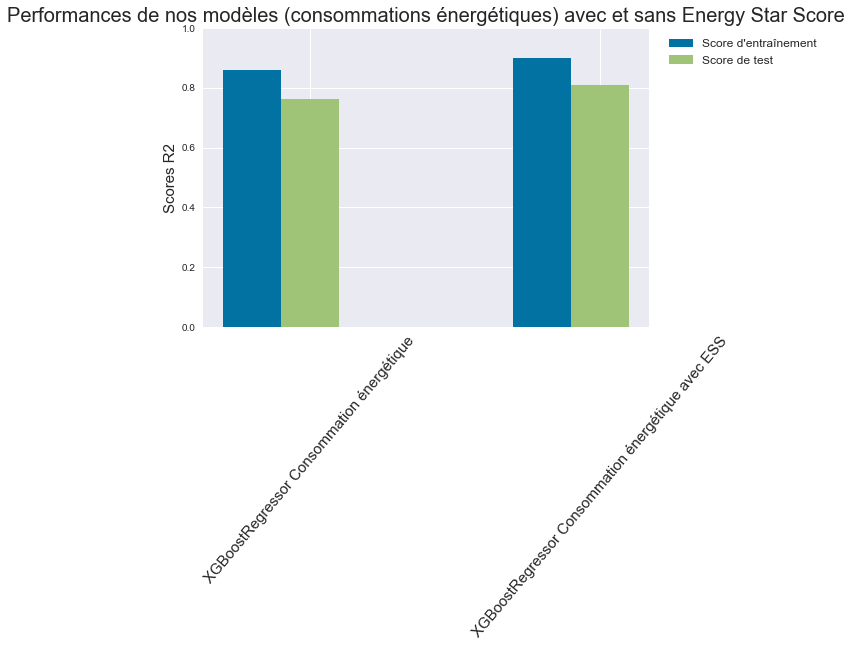

In [38]:
x = df_final.index[:2]
y = df_final["Score d'entraînement"][:2]
z = df_final['Score de test'][:2]
w = df_final['RMSE'][:2]
v = df_final['Temps de calcul'][:2]

_x = np.arange(len(x))

plt.style.use('seaborn-darkgrid')
plt.bar(_x-0.2, y, 0.2, color = 'b', align = 'center')
plt.bar(_x, z, 0.2, color = 'g', align = 'center')
plt.xticks(_x, x, rotation = 50, fontsize = 15)
plt.ylim([0, 1])
plt.ylabel('Scores R2', fontsize = 15)

plt.title('Performances de nos modèles (consommations énergétiques) avec et sans Energy Star Score', fontsize = 20)
plt.legend(["Score d'entraînement", 'Score de test'], bbox_to_anchor = (1.4, 1.), fontsize = 12)

plt.show()

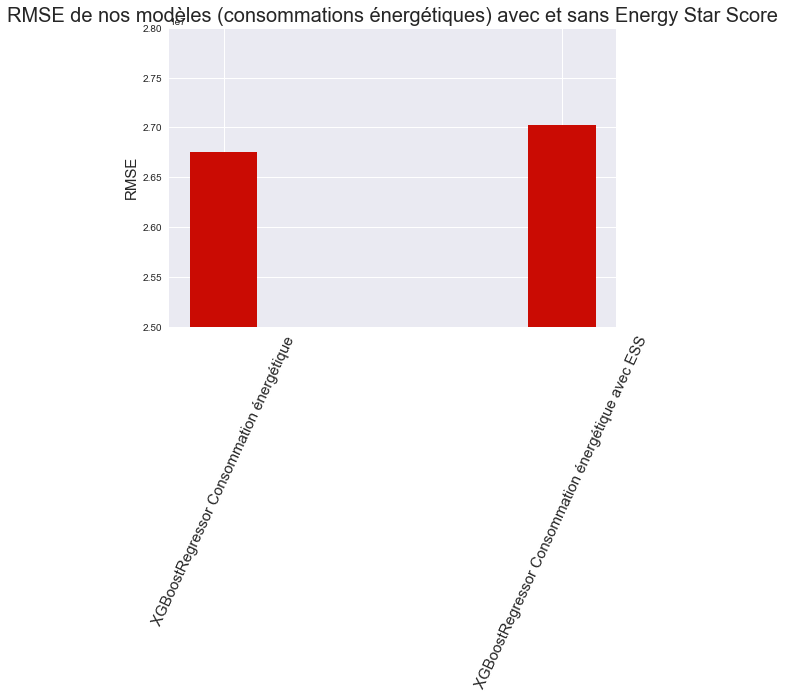

In [39]:
plt.bar(_x, w, 0.2, color = 'r', align = 'center')
plt.ylabel('RMSE', fontsize = 15)
plt.ylim([25000000, 28000000])
plt.xticks(_x, x, rotation = 65, fontsize = 15)
plt.title('RMSE de nos modèles (consommations énergétiques) avec et sans Energy Star Score', fontsize = 20)

plt.show()

## Emissions de CO2

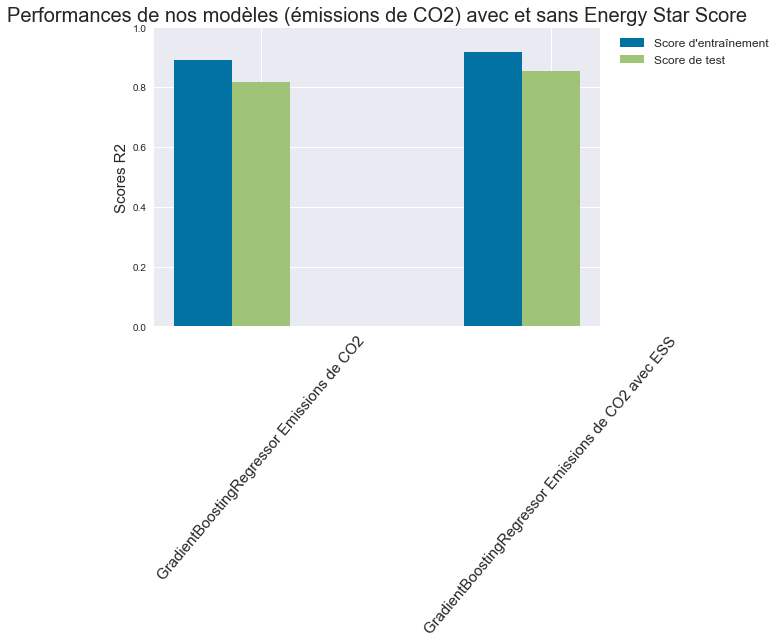

In [40]:
x = df_final.index[2:]
y = df_final["Score d'entraînement"][2:]
z = df_final['Score de test'][2:]
w = df_final['RMSE'][2:]
v = df_final['Temps de calcul'][2:]

_x = np.arange(len(x))

plt.style.use('seaborn-darkgrid')
plt.bar(_x-0.2, y, 0.2, color = 'b', align = 'center')
plt.bar(_x, z, 0.2, color = 'g', align = 'center')
plt.xticks(_x, x, rotation = 50, fontsize = 15)
plt.ylim([0, 1])
plt.ylabel('Scores R2', fontsize = 15)

plt.title('Performances de nos modèles (émissions de CO2) avec et sans Energy Star Score', fontsize = 20)
plt.legend(["Score d'entraînement", 'Score de test'], bbox_to_anchor = (1.4, 1.), fontsize = 12)

plt.show()

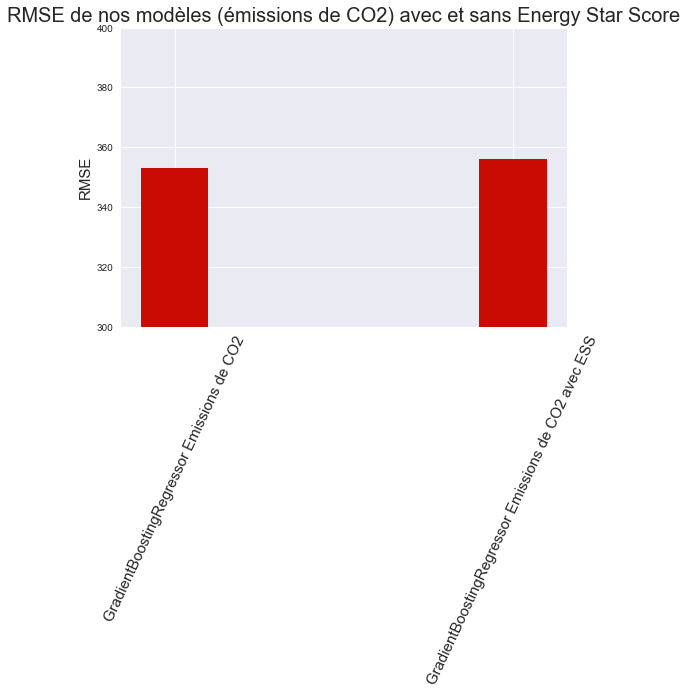

In [41]:
plt.bar(_x, w, 0.2, color = 'r', align = 'center')
plt.ylabel('RMSE', fontsize = 15)
plt.ylim([300, 400])
plt.xticks(_x, x, rotation = 65, fontsize = 15)
plt.title('RMSE de nos modèles (émissions de CO2) avec et sans Energy Star Score', fontsize = 20)

plt.show()

## Temps de calcul de tous nos modèles finaux

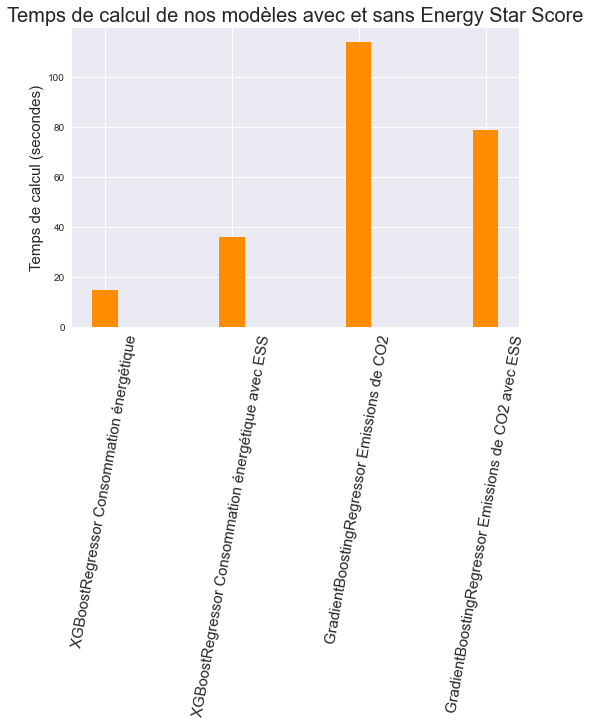

In [42]:
x = df_final.index
v = df_final['Temps de calcul']
_x = np.arange(len(x))

plt.bar(_x, v, 0.2, color = 'darkorange', align = 'center')
plt.ylabel('Temps de calcul (secondes)', fontsize = 15)
plt.xticks(_x, x, rotation = 80, fontsize = 15)
plt.title('Temps de calcul de nos modèles avec et sans Energy Star Score', fontsize = 20)

plt.show()